In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
from pandas import read_csv
from scipy.sparse import csr_matrix, issparse
import liana as li

In [2]:
# TODO: move such functions to a common utils folder
from classification.prep_utils import filter_samples
from classification.classify_utils import INVERSE_FUN

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
from classification.processer import DatasetHandler

In [4]:
interactions = pd.read_csv('ct_interactions.csv')

In [5]:
dataset_name = 'kuppe'
ds = DatasetHandler('kuppe')
dataset_info = ds.dataset_params['kuppe']
defaults = ds.dataset_params['defaults']

In [6]:
dataset_name = dataset_name
groupby = 'cell_type_original' # NOTE: the same cell types but readable
sample_key = dataset_info.get('sample_key', defaults['sample_key'])
condition_key = dataset_info.get('condition_key', defaults['condition_key'])
min_cells_per_sample = dataset_info.get('min_cells_per_sample', defaults['min_cells_per_sample'])
sample_zcounts_max = dataset_info.get('sample_zcounts_max', defaults['sample_zcounts_max'])
sample_zcounts_min = dataset_info.get('sample_zcounts_min', defaults['sample_zcounts_min'])
min_cells = dataset_info.get('min_cells', defaults['min_cells'])
min_samples = dataset_info.get('min_samples', defaults['min_samples'])
use_raw = dataset_info.get('use_raw', defaults['use_raw'])
change_var_to = dataset_info.get('change_var_to', defaults['change_var_to'])
conditions_to_keep = dataset_info.get('conditions_to_keep', defaults['conditions_to_keep'])
n_factors = dataset_info.get('n_factors', defaults['n_factors'])

Process Full Dataset

In [ ]:
adata = sc.read_h5ad(os.path.join('classification', 'data', 'kuppe.h5ad'), backed='r')

In [ ]:
# remap
remap = {'vSMCs':'Vascular_SMCs'}
adata.obs[groupby].replace(remap, inplace=True)

In [ ]:
adata.obs[groupby]

In [ ]:
# keep only targets of interest
msk = adata.obs[groupby].isin(interactions['target'])

In [ ]:
adata = adata[msk, :]

In [ ]:
adata = adata.raw.to_adata()

In [ ]:
adata = filter_samples(adata, 
                        sample_key = sample_key,
                        condition_key = condition_key,
                        min_cells_per_sample= min_cells_per_sample,
                        sample_zcounts_max= sample_zcounts_max,
                        sample_zcounts_min= sample_zcounts_min)

In [ ]:
import gc
gc.collect()

In [ ]:
# Remove genes expressed in few cells, normalize
sc.pp.filter_genes(adata, min_cells=min_cells)

In [ ]:
# Change to Gene Symbol
adata.var.index = adata.var[change_var_to]

In [ ]:
adata.layers['counts'] = adata.X.copy()

In [ ]:
# Normalize
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [ ]:
# write to file
adata.write_h5ad(os.path.join('kuppe_visium', 'kuppe_processed.h5ad'))

In [ ]:
adata = sc.read_h5ad(os.path.join('kuppe_visium', 'kuppe_processed.h5ad'), backed='r')

In [ ]:
import gc
gc.collect()

In [ ]:
# Run LIANA (NOTE: should be by method in a sep function)
li.mt.rank_aggregate.by_sample(adata, 
                               groupby=groupby,
                               use_raw=False,
                               sample_key=sample_key,
                               verbose=True,
                               n_perms=None
                               )

In [ ]:
# write to file
adata.write_h5ad(os.path.join('kuppe_visium', 'kuppe_processed.h5ad'))

Run LIANA + MOFA

In [7]:
import muon as mu
import plotnine as p9
import mofax as mofa

In [8]:
adata = sc.read_h5ad(os.path.join('kuppe_visium', 'kuppe_processed.h5ad'), backed='r')

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


In [9]:
mdata = li.multi.lrs_to_views(adata,
                              score_key='magnitude_rank',
                              inverse_fun=INVERSE_FUN,
                              obs_keys=[condition_key], # add those to mdata.obs
                              lr_prop = 0.33, # minimum required proportion of samples to keep an LR
                              lrs_per_sample = 5, # minimum number of interactions to keep a sample in a specific view
                              lrs_per_view = 15, # minimum number of interactions to keep a view
                              samples_per_view = 5, # minimum number of samples to keep a view
                              min_variance = 0, # minimum variance to keep an interaction
                              lr_fill = 0, # fill missing LR values across samples with this
                              verbose=True
                              )

100%|██████████| 36/36 [00:00<00:00, 37.15it/s]


In [10]:
# join target and predictor
# Predictor as Source
interactions['interactions'] = interactions['predictor'] + '&' + interactions['target']

# join the same but with predictor and target swapped
interactions2 = interactions.copy()
interactions2['interactions'] = interactions2['target'] + '&' + interactions2['predictor']
# merge
interactions = pd.concat([interactions, interactions2], axis=0)

In [11]:
interactions = interactions.drop_duplicates(subset=['interactions'])

In [12]:
# each target to {target}&{target}
autocrine = list(interactions['target'].unique())
autocrine = [x + '&' + x for x in autocrine]

In [13]:
ints = list(interactions['interactions'])
# add autocrine (target x target)
ints = ints + autocrine


In [14]:
# intesect
ints = np.intersect1d(list(mdata.mod.keys()), ints)

In [15]:
# keep only keys in ints
views = {}
for k in ints:
    views[k] = mdata.mod[k]

In [16]:
mdata = mu.MuData(views, obs=mdata.obs, var=mdata.var)

In [17]:
mdata

MuData object with n_obs × n_vars = 28 × 7451
  obs:	'patient_group'
  28 modalities
    Cardiomyocyte&Cardiomyocyte:	28 x 381
    Cardiomyocyte&Endothelial:	28 x 287
    Cardiomyocyte&Fibroblast:	28 x 337
    Cardiomyocyte&Pericyte:	28 x 259
    Endothelial&Cardiomyocyte:	28 x 302
    Endothelial&Endothelial:	28 x 226
    Endothelial&Fibroblast:	28 x 245
    Endothelial&Myeloid:	28 x 196
    Endothelial&Pericyte:	28 x 196
    Endothelial&Vascular_SMCs:	28 x 282
    Fibroblast&Cardiomyocyte:	28 x 377
    Fibroblast&Endothelial:	28 x 287
    Fibroblast&Fibroblast:	28 x 328
    Fibroblast&Myeloid:	28 x 259
    Fibroblast&Pericyte:	28 x 255
    Fibroblast&Vascular_SMCs:	28 x 364
    Myeloid&Endothelial:	28 x 172
    Myeloid&Fibroblast:	28 x 205
    Myeloid&Myeloid:	28 x 188
    Myeloid&Pericyte:	28 x 165
    Pericyte&Cardiomyocyte:	28 x 308
    Pericyte&Endothelial:	28 x 217
    Pericyte&Fibroblast:	28 x 262
    Pericyte&Myeloid:	28 x 197
    Pericyte&Pericyte:	28 x 202
    Vascular_SMCs&Endothelial:	28 x 272
    Vascular_SMCs&Fibroblast:	28 x 318
    Vascular_SMCs&Vascular_SMCs:	28 x 364

In [18]:
model = mu.tl.mofa(mdata,
                   use_obs='union',
                   convergence_mode='slow',
                   outfile='models/mofatalk.h5ad',
                   seed=1337,
                   n_factors=10,
                #    copy=True
                )


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='Cardiomyocyte&Cardiomyocyte' group='group1' with N=28 samples and D=381 features...
Loaded view='Cardiomyocyte&Endothelial' group='group1' with N=28 samples and D=287 features...
Loaded view='Cardiomyocyte&Fibroblast' group='group1' with N=28 samples and D=337 features...
Loaded view='Cardiomyocyte&Pericyte' group='group1' with N=28 samples and D=259 features...
Loa

In [19]:
# obtain factor scores
factor_scores = li.ut.get_factor_scores(mdata, obsm_key='X_mofa', obs_keys=condition_key)
factor_scores.head()

,sample,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,patient_group
0,CK158,-3.593064,-0.929223,-0.365716,-0.525252,-0.214421,-0.048715,0.030225,-0.123717,-0.120356,0.022981,myogenic
1,CK159,0.503946,-0.938586,-0.363889,-0.524656,-0.220518,-0.048435,0.028837,-0.124539,-0.122433,0.023054,myogenic
2,CK160,-0.242533,-0.903108,-0.378396,-0.523271,-0.203964,-0.049320,0.030864,-0.122401,-0.118732,0.022658,myogenic
3,CK162,1.079991,-0.932198,-0.365123,-0.524093,-0.220398,-0.048894,0.029265,-0.124132,-0.121569,0.023211,fibrotic
4,CK163,-0.623764,-0.937978,-0.364274,-0.524819,-0.219611,-0.048502,0.028913,-0.124416,-0.122148,0.023109,myogenic


In [20]:
model = mofa.mofa_model("models/mofatalk.h5ad")
model

MOFA+ model: mofatalk.h5ad
Samples (cells): 28
Features: 7451
Groups: group1 (28)
Views: Cardiomyocyte&Cardiomyocyte (381), Cardiomyocyte&Endothelial (287), Cardiomyocyte&Fibroblast (337), Cardiomyocyte&Pericyte (259), Endothelial&Cardiomyocyte (302), Endothelial&Endothelial (226), Endothelial&Fibroblast (245), Endothelial&Myeloid (196), Endothelial&Pericyte (196), Endothelial&Vascular_SMCs (282), Fibroblast&Cardiomyocyte (377), Fibroblast&Endothelial (287), Fibroblast&Fibroblast (328), Fibroblast&Myeloid (259), Fibroblast&Pericyte (255), Fibroblast&Vascular_SMCs (364), Myeloid&Endothelial (172), Myeloid&Fibroblast (205), Myeloid&Myeloid (188), Myeloid&Pericyte (165), Pericyte&Cardiomyocyte (308), Pericyte&Endothelial (217), Pericyte&Fibroblast (262), Pericyte&Myeloid (197), Pericyte&Pericyte (202), Vascular_SMCs&Endothelial (272), Vascular_SMCs&Fibroblast (318), Vascular_SMCs&Vascular_SMCs (364)
Factors: 10
Expectations: W, Z

In [21]:
# total rsq
total_rsq = model.calculate_variance_explained()
total_rsq[['source', 'target']] = total_rsq['View'].str.split('&', 1, expand=True)

In [22]:
factor_of_interest = "Factor1"

In [23]:
# get variance explained by view and factor
rsq = model.get_r2()
factor_rsq = rsq[rsq['Factor']==factor_of_interest]
# separate view column
factor_rsq[['source', 'target']] = factor_rsq['View'].str.split('&', 1, expand=True)

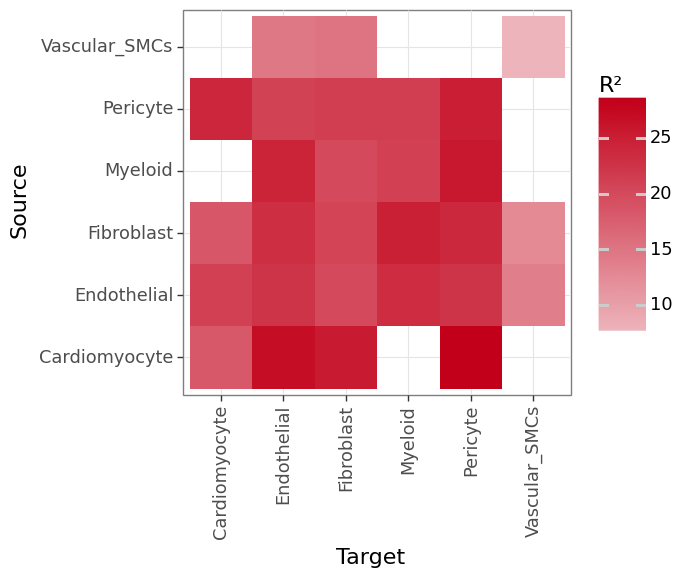

<ggplot: (8791564360885)>

In [24]:
(p9.ggplot(factor_rsq.reset_index()) +
 p9.aes(x='target', y='source') +
 p9.geom_tile(p9.aes(fill='R2')) +
 p9.scale_fill_gradient2(low='white', high='#c20019') +
 p9.theme_bw(base_size=16) +
 p9.theme(figure_size=(5, 5)) +
 p9.labs(x='Target', y='Source', fill='R²') +
 p9.theme(axis_text_x=p9.element_text(rotation=90))
 )

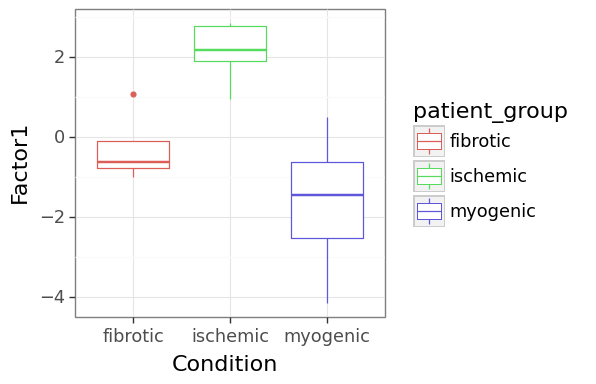

<ggplot: (8791565332015)>

In [25]:
# scatterplot
(p9.ggplot(factor_scores) +
 p9.aes(x=condition_key, colour=condition_key, y=factor_of_interest) +
 p9.geom_boxplot() +
 p9.theme_bw(base_size=16) +
 p9.theme(figure_size=(4, 4)) +
#  p9.scale_colour_manual(values=['#1f77b4', '#c20019']) +
 p9.labs(x='Condition')
 )

In [26]:
variable_loadings =  li.ut.get_variable_loadings(mdata,
                                                 varm_key='LFs',
                                                 view_sep=':',
                                                 pair_sep="&",
                                                 variable_sep="^") # get loadings for factor 1
variable_loadings.head()

# here we will just assign the size of the dots, but this can be replace by any other statistic
variable_loadings['size'] = 4.5



In [27]:
# target = Myeloid and source = Fibroblast
myeloid_loadings = variable_loadings[(variable_loadings['source']=='Myeloid') & (variable_loadings['target']=='Fibroblast')]

In [28]:
myeloid_loadings.sort_values(by="Factor1", ascending=False, key=False).head(20)

,ligand_complex,receptor_complex,source,target,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,size
4903,PLTP,ABCA1,Myeloid,Fibroblast,0.139625,0.111283,-0.056395,0.015369,-0.014085,0.268158,0.026491,-0.014140,-0.042615,0.048411,4.5
4914,SERPINE1,LRP1,Myeloid,Fibroblast,0.054908,0.624547,-0.221847,0.042990,-0.004702,0.294115,-0.106657,0.045244,-0.016076,-0.015989,4.5
4844,FN1,ITGAV_ITGB1,Myeloid,Fibroblast,0.012821,0.561825,-0.206165,0.025969,0.147721,0.071597,-0.024936,0.015819,-0.046743,-0.013223,4.5
4890,NCAM1,CACNA1C,Myeloid,Fibroblast,0.010467,-0.101405,-0.027528,0.168781,-0.033989,0.039266,0.001735,-0.013415,0.104611,0.002397,4.5
4841,FN1,CD44,Myeloid,Fibroblast,0.008788,0.553185,-0.220465,-0.019380,0.379741,-0.009921,-0.020234,0.018712,-0.037293,-0.030551,4.5
4917,SORBS1,INSR,Myeloid,Fibroblast,0.006442,-0.037456,0.118309,0.435194,-0.052953,0.202485,-0.009448,-0.028465,-0.064706,0.000446,4.5
4937,THBS1,LRP1,Myeloid,Fibroblast,0.006140,0.297074,-0.088705,0.016394,0.152338,0.146024,-0.068822,0.019861,1.692870,-0.023634,4.5
4795,COL1A2,CD36,Myeloid,Fibroblast,0.001269,0.901734,-0.520681,0.620990,-0.000666,1.708968,0.634956,-0.305205,-0.003237,-0.012607,4.5
4953,VEGFA,NRP1,Myeloid,Fibroblast,0.001010,0.302670,-0.187562,0.058666,-0.000924,0.048466,-0.015651,0.035756,0.444479,-0.045862,4.5
4924,TFPI,LRP1,Myeloid,Fibroblast,0.000766,0.341486,0.147553,0.024388,-0.001123,0.148810,-0.018378,0.136109,-0.005747,0.670984,4.5


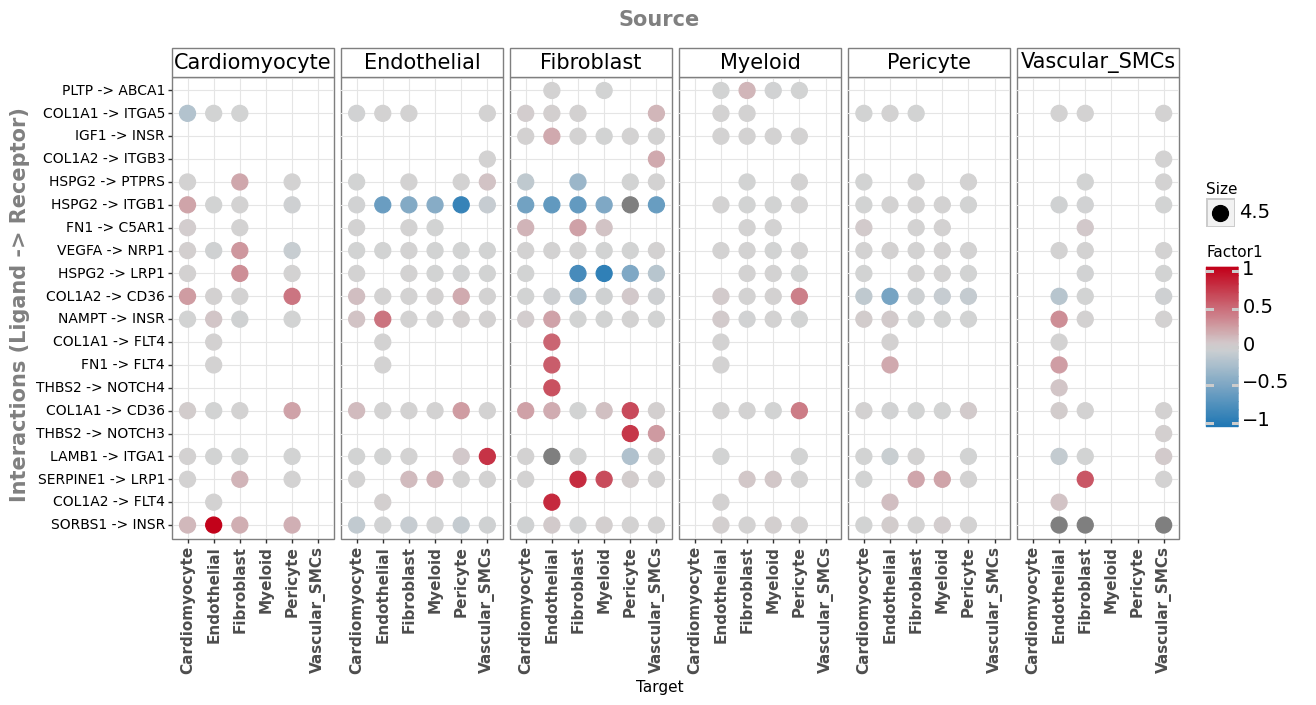

<ggplot: (8791760911967)>

In [29]:
my_plot = li.pl.dotplot(liana_res = variable_loadings,
                        size='size',
                        colour=factor_of_interest,
                        orderby=factor_of_interest,
                        top_n=20,
                        orderby_absolute=False,
                        orderby_ascending=False,
                        size_range=(0.1, 6),
                        figure_size=(13, 6)
                        )
# change colour, with mid as white
my_plot + p9.scale_color_gradient2(low='#1f77b4', mid='lightgray', high='#c20019', limits=(-1, 1), midpoint=0)

In [30]:
# mdata.write_h5mu(os.path.join('kuppe_visium', 'kuppe_mofatalk.h5mu'))

PyDESeq2

In [31]:
import numpy as np
import pandas as pd
import scanpy as sc

import plotnine as p9

import liana as li
import decoupler as dc
import omnipath as op

# Import DESeq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [32]:
pdata = dc.get_pseudobulk(
    adata,
    sample_col=sample_key,
    groups_col=groupby,
    layer='counts',
    mode='sum',
    min_cells=10,
    min_counts=10000
)
pdata



KeyboardInterrupt: 

In [ ]:
# IZ vs Rest
pdata.obs['condition'] = 'Rest' # TODO: do on adata
pdata.obs.loc[pdata.obs[condition_key]=='ischemic', 'condition'] = 'IZ'

In [ ]:
condition_key = 'condition'
ref = "Rest"
cond = "IZ"

In [ ]:
%%capture
dea_results = {}
for cell_group in pdata.obs[groupby].unique():
    # Select cell profiles
    ctdata = pdata[pdata.obs[groupby] == cell_group].copy()

    # Obtain genes that pass the edgeR-like thresholds
    # NOTE: QC thresholds might differ between cell types, consider applying them by cell type
    genes = dc.filter_by_expr(ctdata,
                              group=condition_key,
                              min_count=5, # a minimum number of counts in a number of samples
                              min_total_count=10 # a minimum total number of reads across samples
                              )

    # Filter by these genes
    ctdata = ctdata[:, genes].copy()

    # Build DESeq2 object
    dds = DeseqDataSet(
        adata=ctdata,
        design_factors=condition_key,
        ref_level=[condition_key, 'Rest'],
        refit_cooks=True,
        n_cpus=None,
    )

    # Compute LFCs
    dds.deseq2()
    # Contrast between stim and ctrl
    stat_res = DeseqStats(dds, contrast=[condition_key, cond, ref], n_cpus=8)
    # Compute Wald test
    stat_res.summary()
    # Shrink LFCs
    stat_res.lfc_shrink(coeff=f'{condition_key}_{cond}_vs_{ref}') # {condition_key}_cond_vs_ref

    dea_results[cell_group] = stat_res.results_df


In [ ]:
# concat results across cell types
dea_df = pd.concat(dea_results)

In [ ]:
dea_df = dea_df.reset_index().rename(columns={'level_0': groupby})

In [ ]:
dea_df.set_index('feature_name', inplace=True)

In [ ]:
dea_df.to_csv(os.path.join('kuppe_visium', 'kuppe_dea.csv'))

In [40]:
dea_df = pd.read_csv(os.path.join('kuppe_visium', 'kuppe_dea.csv'), index_col=0)

In [33]:
# keep only iz
adata_s = adata[adata.obs['patient_group']=='ischemic', :] # change to condition key when in adata

In [34]:
adata_s = adata_s.to_memory()

In [35]:
adata_s.X = adata_s.layers['counts'].copy()


In [36]:
adata_s.X.max()

4559.0

In [37]:
sc.pp.normalize_total(adata_s, target_sum=1e4)
sc.pp.log1p(adata_s)
# NOTE: it's not already log-transformed (its something with the way it's saved)

In [41]:
lr_res = li.multi.df_to_lr(adata_s,
                           dea_df=dea_df,
                           resource_name='consensus',
                           expr_prop=0.1, # calculated for adata as passed - used to filter interactions
                           groupby=groupby,
                           stat_keys=['stat', 'pvalue', 'padj'],
                           use_raw=False,
                           complex_col='stat', # NOTE: we use the Wald Stat to deal with complexes
                           verbose=True,
                           return_all_lrs=False,
                           )

Using resource `consensus`.
Using `.X`!
3970 features of mat are empty, they will be removed.
['RMRP_ENSG00000269900', 'ALG1L9P_ENSG00000248671', 'RP11-436O19__A.6', 'LINC01830_ENSG00000234207', 'LINC00486_ENSG00000230876', 'SLFN12L_ENSG00000205045', 'POLR2J3_ENSG00000285437', 'SIGLEC5_ENSG00000105501', 'DNAJC9-AS1_ENSG00000227540', 'ITFG2-AS1_ENSG00000258325', 'FAM153B_ENSG00000182230', 'RAET1E-AS1_ENSG00000268592', 'PINX1_ENSG00000254093', 'SPATA13_ENSG00000182957', 'DUXAP8_ENSG00000206195', 'DGCR5_ENSG00000273032', 'RP4-633O19__A.1', 'LINC00941_ENSG00000285517', 'DNAJC9-AS1_ENSG00000236756', 'LINC00486_ENSG00000236854', 'RNU11_ENSG00000270103', 'CLCA4-AS1_ENSG00000236915', 'RP11-99J16__A.2', 'LINC01115_ENSG00000237667', 'LINC01605_ENSG00000253161', 'XXyac-YX65C7_A.2', 'LINC01830_ENSG00000228999', 'RPPH1_ENSG00000259001', 'PRICKLE2-AS1_ENSG00000241111', 'RP1-213J1P__B.1', 'CCDC39_ENSG00000284862', 'SCARNA2_ENSG00000270066', 'RGS5_ENSG00000232995', 'RP11-1157N2__B.2', 'RNU12_ENSG00000

Pick interactions of interst based on R2

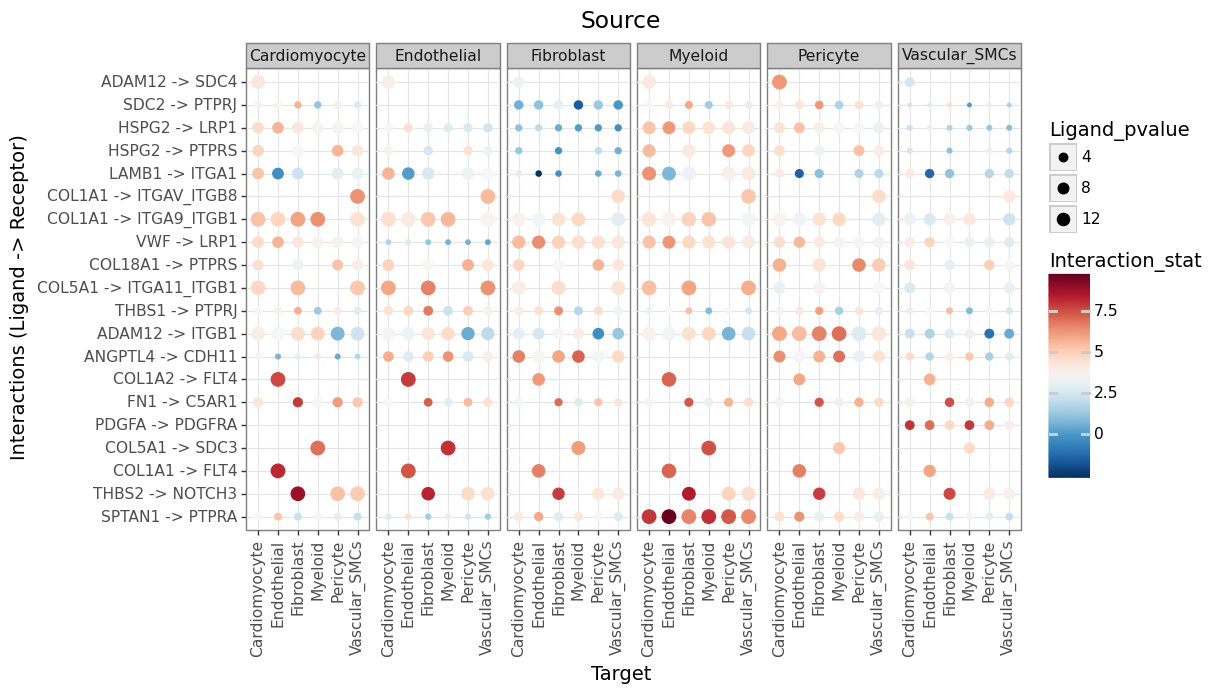

<ggplot: (8791568358953)>

In [43]:
plot = li.pl.dotplot(liana_res=lr_res,
                     colour='interaction_stat',
                     size='ligand_pvalue',
                     inverse_size=True,
                     orderby='interaction_stat',
                     orderby_ascending=False,
                     top_n=20,
                     size_range=(1, 5)
                     )

# customize plot
(
    plot
    + p9.theme_bw(base_size=14)
    # fill cmap blue to red
    + p9.scale_color_cmap('RdBu_r')
    # rotate x
    + p9.theme(axis_text_x=p9.element_text(angle=90), figure_size=(10, 6))
)



This one on CT of interest

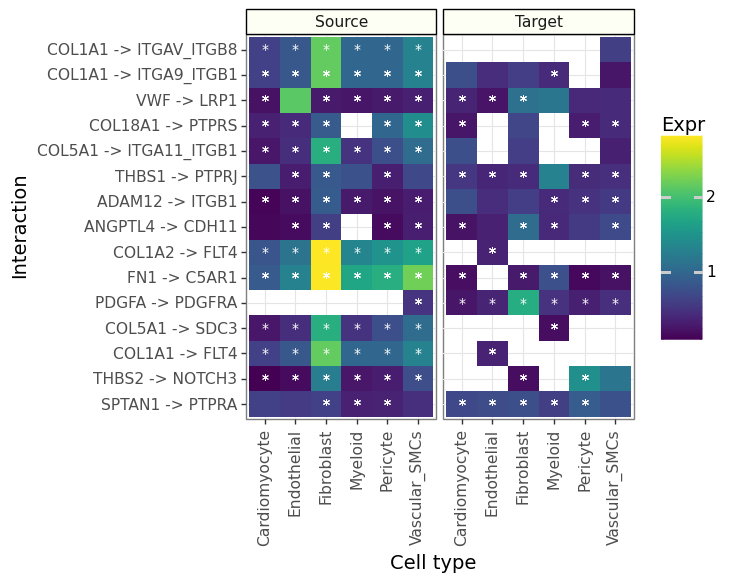

<ggplot: (8791560437917)>

In [44]:
li.pl.tileplot(liana_res=lr_res,
               fill = 'expr',
               label='padj',
               label_fun = lambda x: '*' if x < 0.05 else np.nan,
               top_n=15,
               orderby = 'interaction_stat',
               orderby_ascending = False,
               orderby_absolute = False,
               )



Save DE interactions -> go space

In [ ]:
import omnipath as op

In [ ]:
cpdb = op.interactions.import_intercell_network(interactions_params={'databases': ['CellPhoneDB'], 'genesymbols':True}, transmitter_params={'databases': ['CellPhoneDB']}, receiver_params={'databases': ['CellPhoneDB']})

In [ ]:
cpdb[['source_genesymbol', 'target_genesymbol']].drop_duplicates()

Cell Type Dependencies

In [ ]:
factor_rsq['weight'] = factor_rsq['R2']/max(factor_rsq['R2'])

In [ ]:
import networkx as nx

In [ ]:
factor_rsq.head()

In [ ]:
# drop self loops
g = factor_rsq[factor_rsq['source']!=factor_rsq['target']]
g = nx.from_pandas_edgelist(g, source='source', target='target', edge_attr=['weight'])

In [ ]:
edges = g.edges()
# colors = ['red' if g[u][v]['weight'] > 0 else 'blue' for u,v in edges]
weights = [abs(g[u][v]['weight']) for u,v in edges]
weights = np.log2(weights) + 0.5

In [ ]:
nx.draw(
    g,
    with_labels=True,
    # edge_color=colors,
    width=weights,
    alpha=1,
    node_size=700,
    node_color='white',
    edgecolors='gray',
    # change graph layout to circle
    pos=nx.circular_layout(g),
)

In [ ]:
plt.show()

In [ ]:
factor_rsq

In [ ]:
from pycirclize import Circos
import pandas as pd
# pivot wide
matrix_df = factor_rsq.pivot(index='source', columns='target', values='weight')

In [ ]:
# remove index names
matrix_df.index.name = None
# replace NA with 0
matrix_df = matrix_df.fillna(0)
# matrix_df = matrix_df / matrix_df.values.max()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Initialize Circos from matrix for plotting Chord Diagram
circos = Circos.initialize_from_matrix(
    matrix_df,
    space=5,
    cmap="tab10",
    label_kws=dict(size=12),
    link_kws=dict(ec="black", lw=0.5, direction=1),
)

In [ ]:
circos.plotfig()